## SDF Library

In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax
from timeit import default_timer as timer


In [2]:
def _length(a):
    return jnp.linalg.norm(a, axis=1)

def _soft_plus(value):
    return jax.nn.softplus(50 * value) / 50

def _soft_minus(value):
    return -jax.nn.softplus(50 * -value) / 50

ORIGIN = jnp.array((0, 0))

SEED = jax.random.PRNGKey(0)
def seed():
    global SEED
    SEED, _ = jax.random.split(SEED)

def circle(radius=1, center=(0, 0)):
    center = jnp.array(center)
    def f(p):
        return _length(p - center) - radius

    return f

def translate(sdf, offset):
    offset = jnp.array(offset)
    def f(p):
        return sdf(p - offset)

    return f


def rotate(sdf, angle):
    s = jnp.sin(angle)
    c = jnp.cos(angle)
    m = 1 - c
    matrix = jnp.array(
        [
            [c, -s],
            [s, c],
        ]
    ).T

    def f(p):
        return sdf(jnp.dot(p, matrix))

    return f

def rotate_around_center(sdf, angle, center):
    center = jnp.array(center)

    def f(p):
        v = translate(rotate(translate(sdf, -center), angle), center)(p)
        return v

    return f

def rectangle(size=1, center=(0, 0)):
    center = jnp.array(center)
    size = jnp.array(size)

    def f(p):
        q = jnp.abs(p - center) - size / 2
        return _length(_soft_plus(q)) + _soft_minus(jnp.amax(q, axis=1))

    return f

def bottom_half_plane(p):
    return p[:, 1]

def intersection(sdf1, sdf2):
    def f(p):
        return jnp.maximum(sdf1(p), sdf2(p))
    return f



In [3]:
def show_sdf(sdf, bounds=(-1, 1), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    plt.imshow(1-inside(sdf)(grid_points).reshape(n, n), cmap="gray", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])

In [4]:
N = 100000
shape = (N, 2)
dtype = jnp.float64

def naive_area(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    computed_sdf = sdf(random_numbers) < 0
    return jnp.sum(computed_sdf) / n * (bounds[1] - bounds[0])**2

In [5]:
def inside(sdf):
   def f(p):
       distance = sdf(p)
       return 1-jax.nn.sigmoid(100* distance)

   return f

In [6]:
def area(sdf, points, bounds=[-1, 1]):
    computed_sdf = inside(sdf)(points)
    return jnp.average(computed_sdf, axis=0) * (bounds[1] - bounds[0])**2


In [7]:
def centroid(sdf, points, bounds=[-1, 1]):
    inside_points = inside(sdf)(points)
    return jnp.average(points, weights=inside_points, axis=0)

## The boat problem

In [8]:
RELATIVE_DENSITY = 0.5
SAMPLE_SIZE = 10000
INTEGRATION_BOUNDS = (-3, 3)

In [9]:
def update_position(original_shape, original_shape_center, p1, p2):
    return translate(rotate_around_center(original_shape, jnp.atan(p1), original_shape_center), (0, p2))

def alignment_cost(shape, points):
    shape_center_of_gravity = centroid(shape, points, bounds=INTEGRATION_BOUNDS)
    shape_area = area(shape, points, bounds=INTEGRATION_BOUNDS)

    shape_weight = shape_area * RELATIVE_DENSITY

    displacement = intersection(bottom_half_plane, shape)
    buoyancy_center = centroid(displacement, points, bounds=INTEGRATION_BOUNDS)

    displacement_weight = area(displacement, points, bounds=INTEGRATION_BOUNDS)

    gravity_cost = displacement_weight - shape_weight
    torque_cost = (buoyancy_center - shape_center_of_gravity)[0]

    costs = jnp.array([gravity_cost, torque_cost])
    return jnp.dot(costs, costs)

#### Helper functions

In [10]:
def center_of_gravity(shape, points):
    return centroid(shape, points, bounds=INTEGRATION_BOUNDS)

def center_of_buoyancy(shape, points):
    displacement = intersection(bottom_half_plane, shape)
    return centroid(displacement, points, bounds=INTEGRATION_BOUNDS)


In [11]:
solver = optax.rmsprop(learning_rate=0.003)

In [12]:
def find_equilibrium(shape, reset_seed=False, sample_size = 10000, iterations=500):
    seed = SEED
    points = jax.random.uniform(seed, (sample_size, 2), jnp.float32, INTEGRATION_BOUNDS[0], INTEGRATION_BOUNDS[1])
    shape_cof = center_of_gravity(shape, points)

    @jax.jit
    def cost(x, pts):
        cost = alignment_cost(update_position(shape, shape_cof, x[0], x[1]), pts)
        return cost

    cost_grad = jax.grad(cost)
    params = (0.,0.)
    opt_state = solver.init(params)
    for i in range(iterations):
        if reset_seed:
            seed, rng = jax.random.split(seed)
            points = jax.random.uniform(rng, (sample_size, 2), jnp.float32, INTEGRATION_BOUNDS[0], INTEGRATION_BOUNDS[1])
        grad = cost_grad(params, points)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        err = cost(params, points)
        if (i % 100 == 0):
            print('Cost: {:.2E}'.format(err))

    print("translation", params[0])
    print("rotation", jnp.atan(params[1]))

    end_shape = update_position(shape, shape_cof, params[0], params[1])

    show_sdf(end_shape, bounds=(-3, 3))

    plt.scatter(*center_of_gravity(end_shape, points), c="red")
    plt.scatter(*center_of_buoyancy(end_shape, points), c="blue")

In [13]:
def grad_at_origin(shape):
    points = jax.random.uniform(SEED, (10000, 2), jnp.float32, INTEGRATION_BOUNDS[0], INTEGRATION_BOUNDS[1])
    shape_cof = center_of_gravity(shape, points)

    def cost(x, y):
        return alignment_cost(update_position(shape, shape_cof, x, y), points)
    return jax.value_and_grad(cost, (0, 1))(jnp.array(0.0), jnp.array(0.0))


### Solving the equilibrium of a rectangle

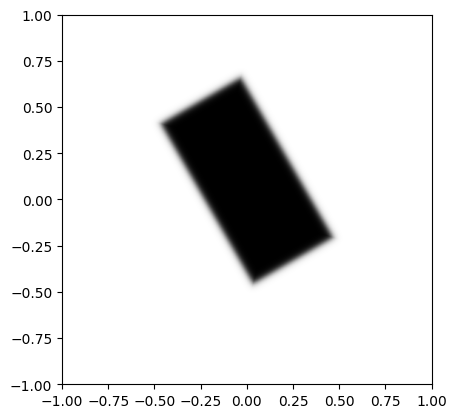

In [14]:
rectangle_sdf = translate(rotate(rectangle((1,0.5)), jnp.pi / 3), (0, 0.1))
show_sdf(rectangle_sdf)

In [15]:
grad_at_origin(rectangle_sdf)

(Array(0.02129858, dtype=float32),
 (Array(-0.06860957, dtype=float32, weak_type=True),
  Array(0.16273999, dtype=float32, weak_type=True)))

Cost: 1.19E-02
Cost: 3.23E-03
Cost: 5.90E-04
Cost: 3.37E-04
Cost: 3.19E-04
translation 0.5744828
rotation -0.08285609


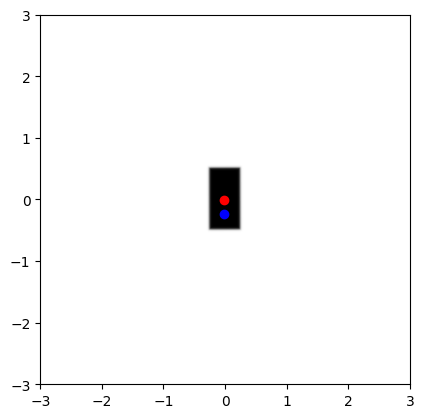

In [16]:
find_equilibrium(rectangle_sdf, True, 10000, 500)

### Solving the equilibrium of a circle

In [17]:
grad_at_origin(circle(1, (0, -0.5)))

(Array(0.9751049, dtype=float32),
 (Array(-0.05767911, dtype=float32, weak_type=True),
  Array(-4.091809, dtype=float32, weak_type=True)))

Cost: 1.18E+00
Cost: 4.61E-02
Cost: 1.31E-01
Cost: 1.85E-02
Cost: 1.73E-02
Cost: 1.30E-02
Cost: 2.21E-02
Cost: 5.56E-03
Cost: 4.48E-03
Cost: 6.92E-03
translation -0.3971846
rotation 0.44623542


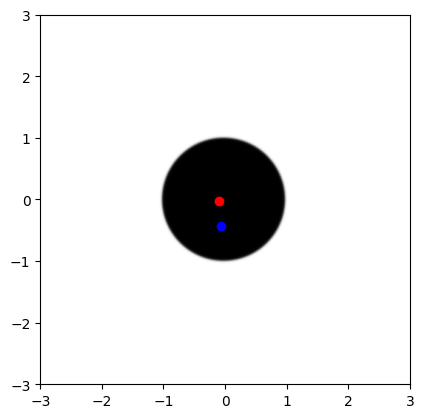

In [18]:
find_equilibrium(circle(1, (0, -0.5)), True, 1000, 1000)

Yeah, it work - but this is only concerned with gravity. Let's try something a bit less symmetrical.

### Solving the equilibrium of a partial circle

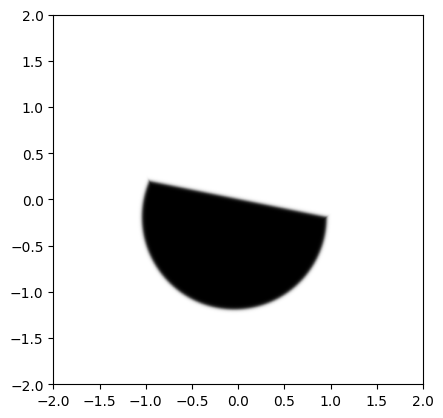

In [19]:
partial_circle = rotate(intersection(translate(circle(), (0, -0.2)), bottom_half_plane), 0.2)

show_sdf(partial_circle, bounds=[-2, 2])

In [20]:
grad_at_origin(partial_circle)

(Array(0.7724121, dtype=float32),
 (Array(-0.8880811, dtype=float32, weak_type=True),
  Array(-1.109529, dtype=float32, weak_type=True)))

Cost: 9.57E-01
Cost: 2.26E-01
Cost: 3.35E-02
Cost: 6.82E-03
Cost: 1.46E-02
translation -0.1452483
rotation 0.45222494


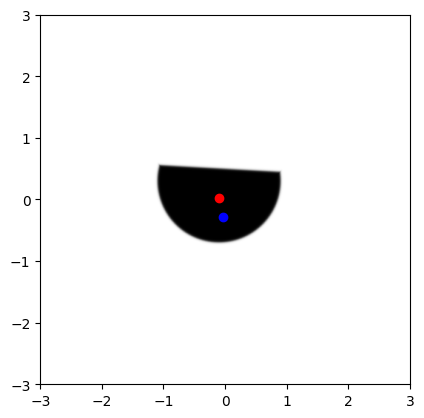

In [21]:
find_equilibrium(partial_circle, True, 1000, 500)